In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [8]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.train.pairs.200K.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]



    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [9]:
MAX_LENGTH = 10




def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [10]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    #pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    i=0
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('de', 'en', False)

Reading lines...
Read 200000 sentence pairs
Trimmed to 200000 sentence pairs
Counting words...
Counted words:
de 208226
en 95003


In [11]:
pairs[0]

['es geht nicht an dass uber ausfuhrungsbestimmungen deren inhalt zweck und ausma vorher nicht bestimmt ist zusammen mit den nationalen burokratien das gesetzgebungsrecht des europaischen parlaments ausgehebelt wird .',
 'it is not acceptable that with the help of the national bureaucracies parliament apos s legislative prerogative should be made null and void by means of implementing provisions whose content purpose and extent are not laid down in advance .']

In [87]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [88]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_output, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [89]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [90]:
variableFromSentence(input_lang, pairs[9][0])
#indexesFromSentence(input_lang, pairs[0][0])


Variable containing:
   55
   56
   57
   58
   59
   60
   61
    7
    1
[torch.LongTensor of size 9x1]

In [91]:
input_lang.n_words

3114

In [92]:
teacher_forcing_ratio = 0.5


def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
   
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            
            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [93]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [94]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [95]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()


    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]
        
 
        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [96]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_output, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
        
        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

In [97]:


def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [98]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
                               1, dropout_p=0.1)

if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

trainIters(encoder1, attn_decoder1, 200000, print_every=5000)

11m 18s (- 441m 7s) (5000 2%) 5.0948
23m 54s (- 454m 14s) (10000 5%) 3.4684
35m 57s (- 443m 25s) (15000 7%) 1.5571
44m 46s (- 403m 2s) (20000 10%) 0.4720
53m 37s (- 375m 25s) (25000 12%) 0.1152
62m 31s (- 354m 17s) (30000 15%) 0.0534
71m 22s (- 336m 28s) (35000 17%) 0.0360
80m 14s (- 320m 57s) (40000 20%) 0.0270
89m 3s (- 306m 44s) (45000 22%) 0.0218
97m 53s (- 293m 40s) (50000 25%) 0.0183
106m 44s (- 281m 24s) (55000 27%) 0.0160
115m 36s (- 269m 44s) (60000 30%) 0.0140
124m 26s (- 258m 26s) (65000 32%) 0.0124
133m 16s (- 247m 30s) (70000 35%) 0.0112
142m 4s (- 236m 48s) (75000 37%) 0.0102
150m 53s (- 226m 20s) (80000 40%) 0.0093
159m 40s (- 216m 1s) (85000 42%) 0.0086
168m 31s (- 205m 58s) (90000 45%) 0.0080
177m 22s (- 196m 3s) (95000 47%) 0.0074
186m 13s (- 186m 13s) (100000 50%) 0.0070
195m 3s (- 176m 28s) (105000 52%) 0.0066
203m 54s (- 166m 50s) (110000 55%) 0.0063
212m 41s (- 157m 12s) (115000 57%) 0.0059
221m 31s (- 147m 41s) (120000 60%) 0.0057
230m 19s (- 138m 11s) (125000 62

In [99]:
evaluateRandomly(encoder1, attn_decoder1)

> click and go .
= click and go .
< click and go . <EOS>

> und wie sieht eins mensch von innen aus .
= und wie sieht ein mensch von innen aus .
< und wie sieht ein mensch von innen aus . <EOS>

> zudem ist den ganze schlicht unspannend .
= zudem ist das ganze schlicht unspannend .
< zudem ist das ganze schlicht unspannend . <EOS>

> fur die landessportbund war herr delp gekommen .
= fur den landessportbund war herr delp gekommen .
< fur den landessportbund war herr delp gekommen . <EOS>

> sehen ihr sich doch herrn messner an .
= sehen sie sich doch herrn messner an .
< sehen sie sich doch herrn messner an . <EOS>

> es konnten aber noch mehr werden .
= es konnten aber noch mehr werden .
< es konnten aber noch mehr werden . <EOS>

> qualitat kann man sehen .
= qualitat kann man sehen .
< qualitat kann man sehen . <EOS>

> bedeutung den jugendalters fur interaktionspadagogische aktivitaten . . .
= bedeutung des jugendalters fur interaktionspadagogische aktivitaten . . .
< bedeutung des

input = so selten sind mir zu finden .
output = so selten sind bisher zu uberlegen . <EOS>


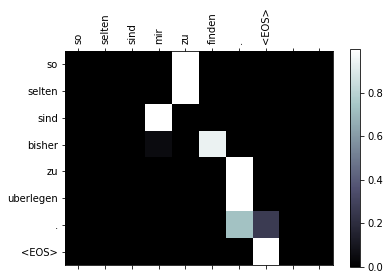

In [123]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
pairs
evaluateAndShowAttention("so selten sind mir zu finden .")

In [84]:

attn_model = 'general'
hidden_size = 256
n_layers = 2
dropout_p = 0.1

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers)
decoder = AttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Move models to GPU
if use_cuda:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.05
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [85]:
# Configuring training
n_epochs = 200000
plot_every = 5000
print_every = 5000

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

In [86]:
# Begin!
for epoch in range(1, n_epochs + 1):
    
    # Get training data for this cycle
    training_pair = variablesFromPair(random.choice(pairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]

    # Run the train function
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

RuntimeError: Expected argument self to have 1 dimension(s), but has 2 at /Users/soumith/miniconda2/conda-bld/pytorch_1503975723910/work/torch/csrc/generic/TensorMethods.cpp:23020